**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zen/opt/anaconda3/envs/envloop

In [42]:
saver = tf.train.Saver()

# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [3]:
df_raw = pd.read_parquet('BTC-USDT.parquet')

df_raw.drop(['volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],1,inplace=True)
df_raw.info()
df_raw.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1764899 entries, 2017-08-17 04:00:00 to 2020-12-29 23:59:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float32
 1   high    float32
 2   low     float32
 3   close   float32
dtypes: float32(4)
memory usage: 40.4 MB


,open,high,low,close
open_time,,,,
2017-08-17 04:00:00,4261.479980,4261.479980,4261.479980,4261.479980
2017-08-17 04:01:00,4261.479980,4261.479980,4261.479980,4261.479980
2017-08-17 04:02:00,4280.560059,4280.560059,4280.560059,4280.560059
2017-08-17 04:03:00,4261.479980,4261.479980,4261.479980,4261.479980
2017-08-17 04:04:00,4261.479980,4261.479980,4261.479980,4261.479980


In [4]:
df_keep_away = df_raw[-100000:].copy(deep=True)

In [5]:
df = df_raw[:-100000].copy(deep=True)

In [6]:
df.tail()

,open,high,low,close
open_time,,,,
2020-10-21 07:24:00,12203.059570,12204.120117,12202.530273,12203.830078
2020-10-21 07:25:00,12203.669922,12203.669922,12194.429688,12197.000000
2020-10-21 07:26:00,12197.000000,12204.309570,12197.000000,12203.230469
2020-10-21 07:27:00,12203.240234,12204.759766,12191.669922,12194.660156
2020-10-21 07:28:00,12194.660156,12197.280273,12192.959961,12196.209961


In [7]:
df.describe()

,open,high,low,close
count,1.664899e+06,1.664899e+06,1.664899e+06,1.664899e+06
mean,7.934037e+03,7.939703e+03,7.928136e+03,7.934021e+03
std,2.724881e+03,2.728407e+03,2.721199e+03,2.724896e+03
min,2.830000e+03,2.830000e+03,2.817000e+03,2.817000e+03
25%,6.318185e+03,6.321710e+03,6.315000e+03,6.318105e+03
50%,7.924300e+03,7.929670e+03,7.919210e+03,7.924340e+03
75%,9.657745e+03,9.663335e+03,9.652000e+03,9.657750e+03
max,1.976204e+04,1.979868e+04,1.974900e+04,1.977074e+04


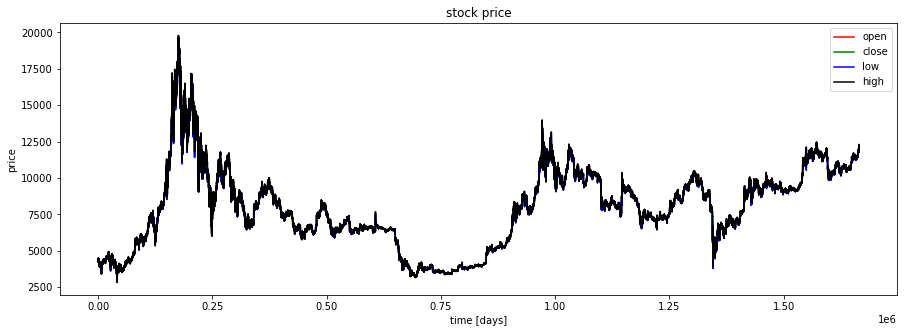

In [8]:
plt.figure(figsize=(15, 5));
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [191]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df['close'].values.reshape(-1,1)
    scale = min_max_scaler.fit(opens + highs + lows + closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (1331903, 19, 4)
y_train.shape =  (1331903, 4)
x_valid.shape =  (166488, 19, 4)
y_valid.shape =  (166488, 4)
x_test.shape =  (166488, 19, 4)
y_test.shape =  (166488, 4)


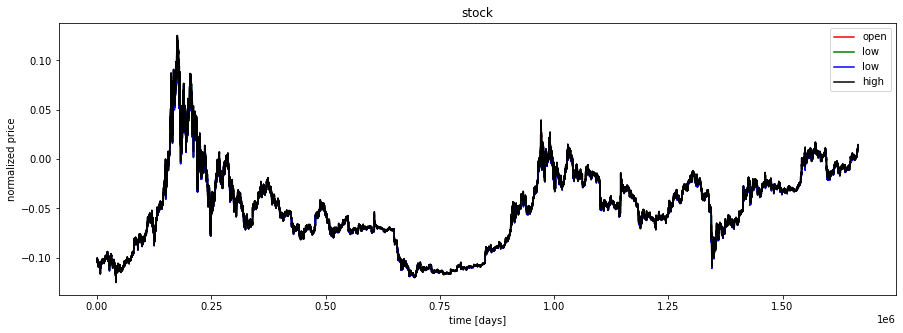

In [192]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [11]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 1 # 200
n_outputs = 4
n_layers = 1 # 2
learning_rate = 0.001
batch_size = 50
n_epochs = 6 # 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]


In [11]:
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [43]:
# run graph
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
    saver.save(sess, 'my_test_model')

0.00 epochs: MSE train/valid = 0.009714/0.005297
5.00 epochs: MSE train/valid = 0.000000/0.000000


In [47]:
y_test_pred

array([[-0.03151388, -0.03150801, -0.0315883 , -0.03155444],
       [-0.03152058, -0.03151471, -0.03159498, -0.03156113],
       [-0.03149175, -0.03148584, -0.0315662 , -0.0315323 ],
       ...,
       [ 0.01325307,  0.01331707,  0.01311529,  0.01320924],
       [ 0.01318675,  0.01325066,  0.01304906,  0.01314291],
       [ 0.0132177 ,  0.01328166,  0.01307997,  0.01317387]],
      dtype=float32)

In [40]:
y_test_pred

array([[-0.03156252, -0.03144189, -0.03165542, -0.03149225],
       [-0.03158867, -0.03146809, -0.03168153, -0.0315184 ],
       [-0.03155599, -0.03143535, -0.0316489 , -0.03148572],
       ...,
       [ 0.01315599,  0.01335486,  0.01297849,  0.01321483],
       [ 0.01306597,  0.01326469,  0.01288864,  0.01312484],
       [ 0.01311912,  0.01331794,  0.01294169,  0.01317798]],
      dtype=float32)

In [12]:
y_test_pred

array([[-0.0315254 , -0.03141161, -0.03169461, -0.03158269],
       [-0.03149969, -0.03138586, -0.03166893, -0.03155698],
       [-0.03147212, -0.03135826, -0.0316414 , -0.03152942],
       ...,
       [ 0.01327769,  0.01344619,  0.01305092,  0.0132146 ],
       [ 0.01313886,  0.01330719,  0.01291227,  0.01307579],
       [ 0.01324077,  0.01340923,  0.01301406,  0.01317769]],
      dtype=float32)

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [13]:
y_train.shape

(1331903, 4)

correct sign prediction for close - open price for train/valid/test: 0.86/0.94/0.90


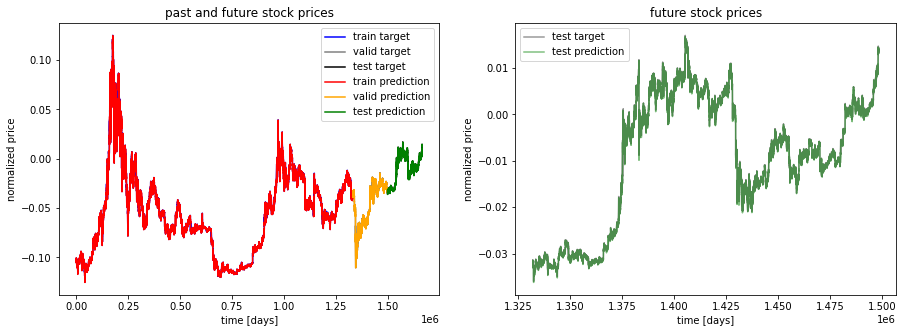

In [35]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target', alpha=0.4)

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction', alpha=0.5)

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


In [109]:
y_test_pred

array([[-0.03151388, -0.03150801, -0.0315883 , -0.03155444],
       [-0.03152058, -0.03151471, -0.03159498, -0.03156113],
       [-0.03149175, -0.03148584, -0.0315662 , -0.0315323 ],
       ...,
       [ 0.01325307,  0.01331707,  0.01311529,  0.01320924],
       [ 0.01318675,  0.01325066,  0.01304906,  0.01314291],
       [ 0.0132177 ,  0.01328166,  0.01307997,  0.01317387]],
      dtype=float32)

In [110]:
x_test

array([[[-0.03160276, -0.03153898, -0.0316029 , -0.0315468 ],
        [-0.0315468 , -0.03152819, -0.03154813, -0.03152819],
        [-0.03152819, -0.031509  , -0.03152819, -0.03152718],
        ...,
        [-0.03146738, -0.03143209, -0.03146753, -0.03144951],
        [-0.03144936, -0.03144611, -0.03148274, -0.03148274],
        [-0.03147905, -0.03135799, -0.03148627, -0.03142752]],

       [[-0.0315468 , -0.03152819, -0.03154813, -0.03152819],
        [-0.03152819, -0.031509  , -0.03152819, -0.03152718],
        [-0.03152718, -0.03152098, -0.03156437, -0.03156039],
        ...,
        [-0.03144936, -0.03144611, -0.03148274, -0.03148274],
        [-0.03147905, -0.03135799, -0.03148627, -0.03142752],
        [-0.0314225 , -0.03139459, -0.03143992, -0.03142574]],

       [[-0.03152819, -0.031509  , -0.03152819, -0.03152718],
        [-0.03152718, -0.03152098, -0.03156437, -0.03156039],
        [-0.03155906, -0.03151241, -0.03156053, -0.0315192 ],
        ...,
        [-0.03147905, -0.03

In [176]:
class scalling_training_data:
    """
    Must use the same value that was used to normalise the trianing data
    
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    
    Class has 2 mathods:
    
    1. scale_data(self, df)
    
        using X_scaled = (X - X_min) / (X_max - X_min),
        returns df that's scaled using self attributes
        
        
    2. rescale_back_data(self, df)
    
        using X_origin = X_scaled * (X_max - X_min) + X_min
        to return the original value after scaled   
    
    """
    
    def __init__(self, s_max_, s_min_, s_scale_, s_scaled_min_):
        self.s_max_ = s_max_
        self.s_min_ = s_min_
        self.s_range_ = self.s_max_ - self.s_min_
        self.s_scale_ = s_scale_
        self.s_scaled_min_ = s_scaled_min_
        
        
    def scale_data(self, df):
        """
        using X_scaled = (X - X_min) / (X_max - X_min),
        returns df that's scaled using self attributes
        """
        
        df = (df - self.s_min_)/self.s_range_
        
        return df
    
    def rescale_back_data(self, df):
        
        df = df * self.s_range_ + self.s_min_
        
        return df

In [ ]:
## put inside a class

def model_scale_data():
#     https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
        
    s_max = 79033.914
    s_min = 11299
    s_range = 67734.914
    s_scale = 1.4763434592168778 * (10**-5)
    s_scaled_min = -0.16681205 ## not going to need this data

In [177]:
BTCUSDT_Scale_train1 = scalling_training_data(  s_max_ = 79033.914,
                                                s_min_ = 11299,
#                                                 s_range_ = 67734.914,
                                                s_scale_ = 1.4763434592168778 * (10**-5),
                                                s_scaled_min_ = -0.16681205
                                             )

In [185]:
df_keep_away_scaled = BTCUSDT_Scale_train1.scale_data(df_keep_away).copy(deep=True)

In [234]:
df_keep_away_scaled

,open,high,low,close
open_time,,,,
2020-10-21 07:29:00,0.013246,0.013246,0.013155,0.013172
2020-10-21 07:30:00,0.013172,0.013361,0.013157,0.013243
2020-10-21 07:31:00,0.013243,0.013314,0.013182,0.013314
2020-10-21 07:32:00,0.013314,0.013317,0.013217,0.013242
2020-10-21 07:33:00,0.013242,0.013279,0.013188,0.013225
...,...,...,...,...
2020-12-29 23:55:00,0.237854,0.237854,0.237327,0.237610
2020-12-29 23:56:00,0.237610,0.237638,0.236988,0.237372
2020-12-29 23:57:00,0.237372,0.237706,0.237305,0.237689


In [248]:
x_test[:1, :, :].shape

(1, 19, 4)

In [258]:
df_keep_away_scaled[:19].values.reshape(1,19,4)

array([[[0.0132459 , 0.01324605, 0.01315467, 0.01317208],
        [0.01317208, 0.01336091, 0.01315746, 0.01324309],
        [0.01324309, 0.01331425, 0.01318169, 0.01331366],
        [0.01331381, 0.01331662, 0.01321652, 0.01324176],
        [0.01324162, 0.01327942, 0.01318817, 0.01322479],
        [0.01322479, 0.01322804, 0.01296717, 0.01307863],
        [0.01307877, 0.01307877, 0.01215961, 0.01246609],
        [0.01246609, 0.01287386, 0.01236334, 0.01271146],
        [0.01270112, 0.01281244, 0.01263691, 0.01279843],
        [0.01279902, 0.01288434, 0.01275133, 0.01277938],
        [0.01277953, 0.01291564, 0.01277953, 0.0129146 ],
        [0.0129146 , 0.01293632, 0.01271279, 0.0127283 ],
        [0.01272814, 0.01282204, 0.01269405, 0.01278911],
        [0.01278927, 0.01285497, 0.01278911, 0.01284861],
        [0.01284861, 0.01292849, 0.01277849, 0.01277894],
        [0.01277894, 0.01291062, 0.01277879, 0.01280404],
        [0.01280404, 0.01284433, 0.0127531 , 0.01284433],
        [0.012

In [352]:
x_unseen = []

In [354]:
for i in np.arange(len(df_keep_away_scaled) - 19):## no need to do -1 here as we can keep the last one as testing
    x_unseen.append(df_keep_away_scaled[i: i + 19].values) #.reshape(1,19,4))
    
x_unseen = np.array(x_unseen)

In [355]:
np.array(x_unseen[-1])

array([[0.23581354, 0.23622958, 0.2358094 , 0.23581974],
       [0.23584011, 0.23584011, 0.2351712 , 0.23544504],
       [0.23544328, 0.23586063, 0.23528813, 0.23568068],
       [0.23568082, 0.23619045, 0.23544769, 0.23612832],
       [0.23612814, 0.23618469, 0.23523083, 0.23583244],
       [0.23583229, 0.23618543, 0.23548359, 0.23565438],
       [0.23565821, 0.23573604, 0.23527984, 0.23541035],
       [0.23538996, 0.235894  , 0.23525533, 0.23576644],
       [0.23576644, 0.23621497, 0.23575787, 0.23615178],
       [0.23615164, 0.23676357, 0.23614512, 0.23676357],
       [0.23676357, 0.23692256, 0.236525  , 0.23668   ],
       [0.23668   , 0.23696789, 0.23652513, 0.23696789],
       [0.23696776, 0.23755844, 0.23689659, 0.23743147],
       [0.23743133, 0.23770607, 0.23741524, 0.23770607],
       [0.23770592, 0.2378537 , 0.23752478, 0.2378537 ],
       [0.2378537 , 0.2378537 , 0.2373268 , 0.2376101 ],
       [0.23760997, 0.23763831, 0.23698843, 0.23737152],
       [0.23737152, 0.23770607,

In [356]:
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('my_test_model.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    y_unseen = sess.run(outputs, feed_dict={X: x_test[:1, :, :]})
    y_unseen2 = sess.run(outputs, feed_dict={X: df_keep_away_scaled[:19].values.reshape(1,19,4)})
    y_unseen_all = sess.run(outputs, feed_dict={X: x_unseen})

INFO:tensorflow:Restoring parameters from ./my_test_model


In [357]:
x_unseen.shape

(99981, 19, 4)

In [358]:
y_unseen_all.shape

(99981, 4)

In [359]:
df_keep_away_scaled.shape

(100000, 4)

In [367]:
y_unseen_predict = pd.DataFrame(y_unseen_all, columns=['u_open','u_high','u_low','u_close'])

In [368]:
y_unseen_predict

,u_open,u_high,u_low,u_close
0,0.012830,0.012893,0.012693,0.012786
1,0.012824,0.012888,0.012687,0.012780
2,0.012834,0.012897,0.012697,0.012790
3,0.012875,0.012939,0.012738,0.012832
4,0.012927,0.012991,0.012790,0.012883
...,...,...,...,...
99976,0.237642,0.237998,0.237187,0.237582
99977,0.237536,0.237891,0.237080,0.237475
99978,0.237257,0.237612,0.236802,0.237197
99979,0.237461,0.237816,0.237005,0.237400


In [369]:
df_compare = df_keep_away_scaled[19:].copy(deep=True)

In [375]:
df_compare = df_compare.reset_index().merge(y_unseen_predict, left_index=True, right_index=True, how='outer').set_index('open_time')

In [378]:
df_compare = BTCUSDT_Scale_train1.rescale_back_data(df_compare)

<AxesSubplot:xlabel='open_time'>

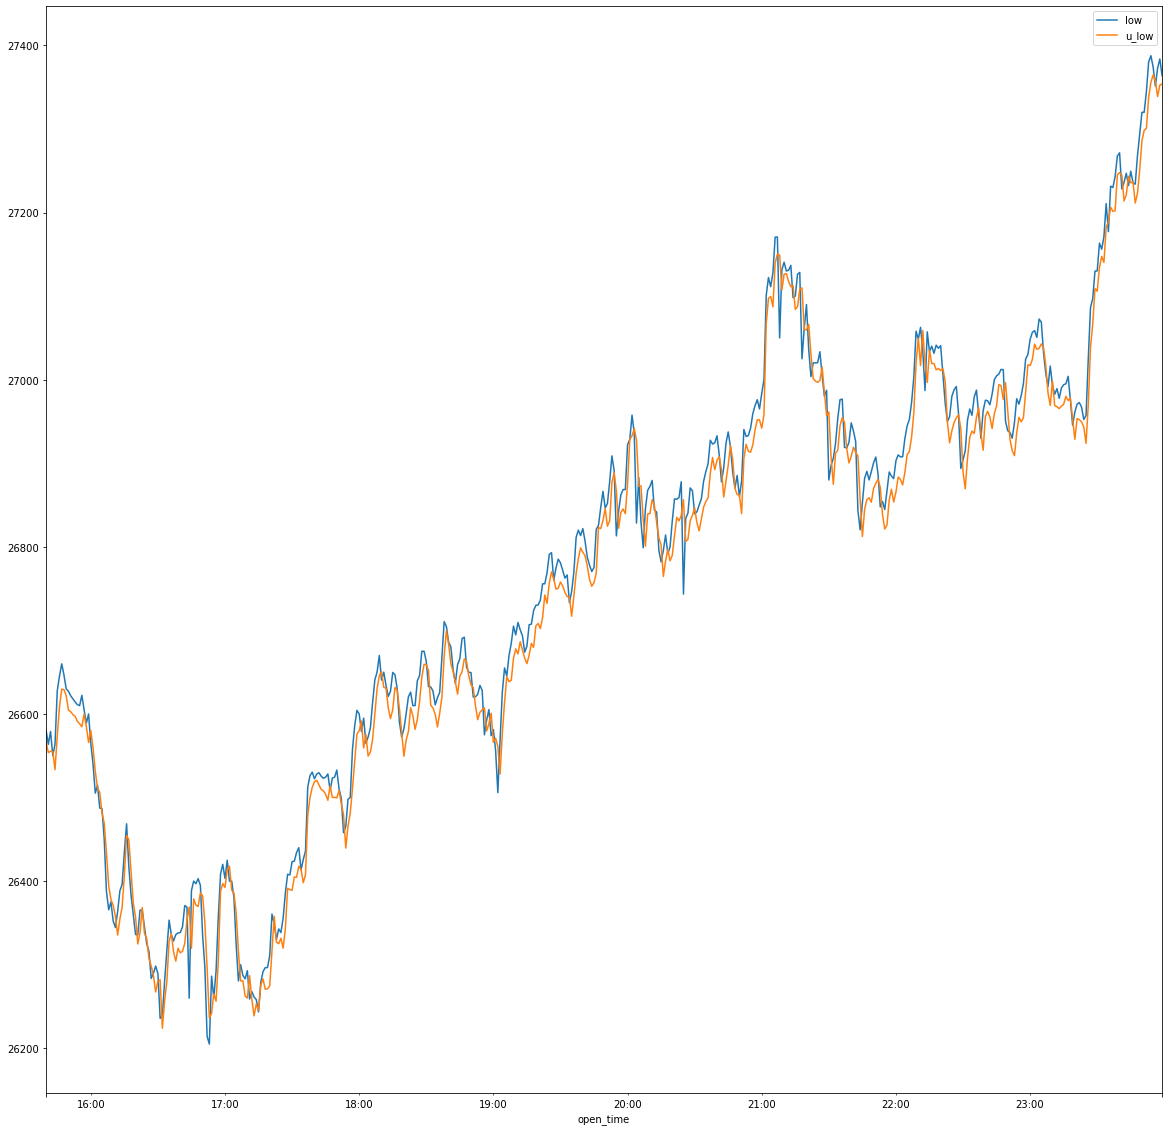

In [390]:
df_compare[['low','u_low']][-500:].plot(figsize=(20,20))

<AxesSubplot:xlabel='open_time'>

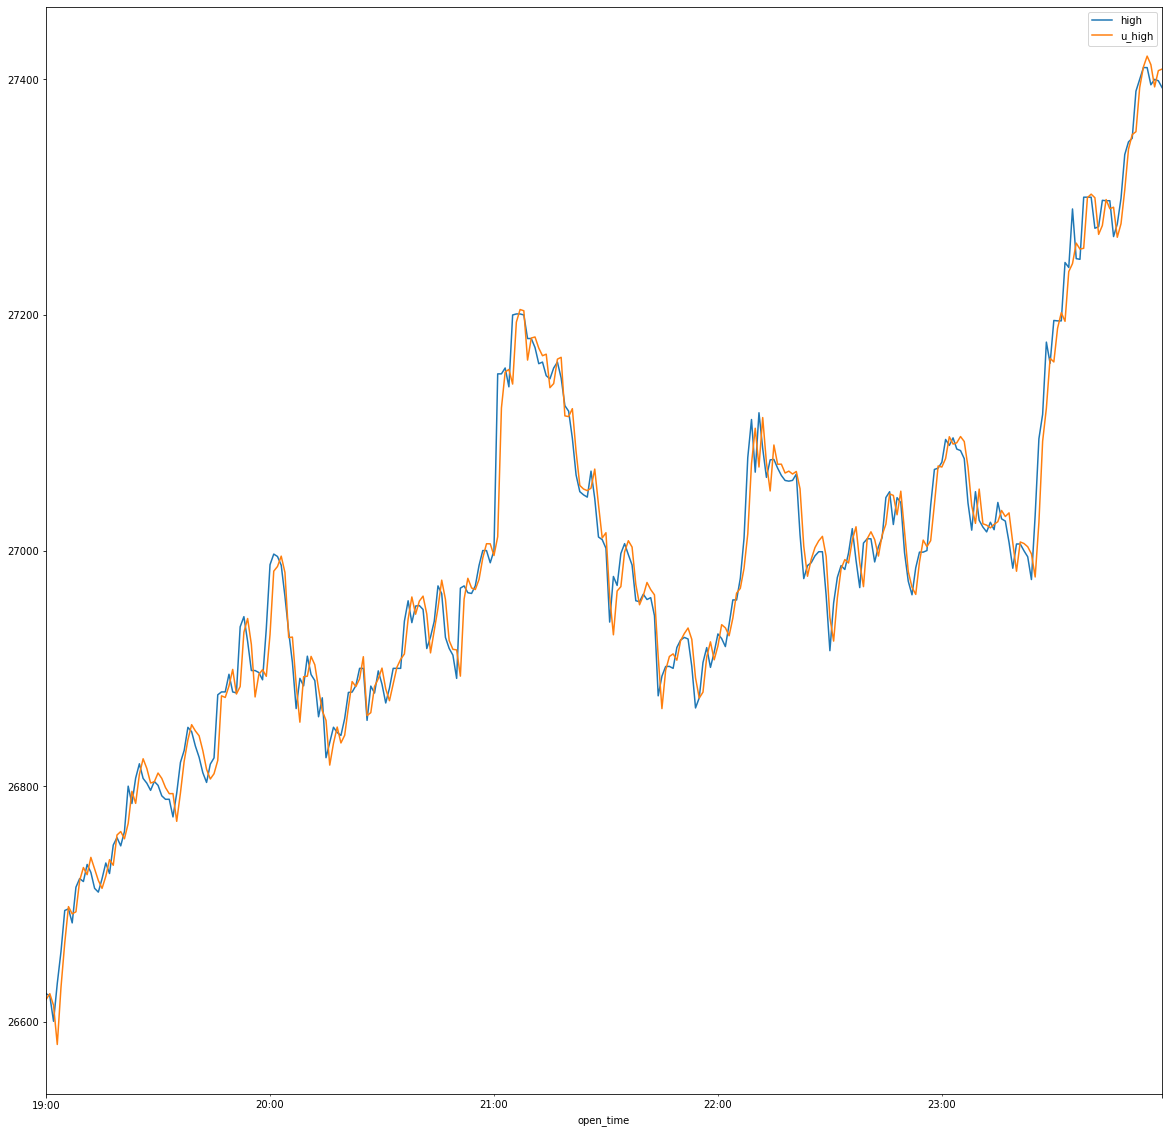

In [388]:
df_compare[['high','u_high']][-300:].plot(figsize=(20,20))

<AxesSubplot:xlabel='open_time'>

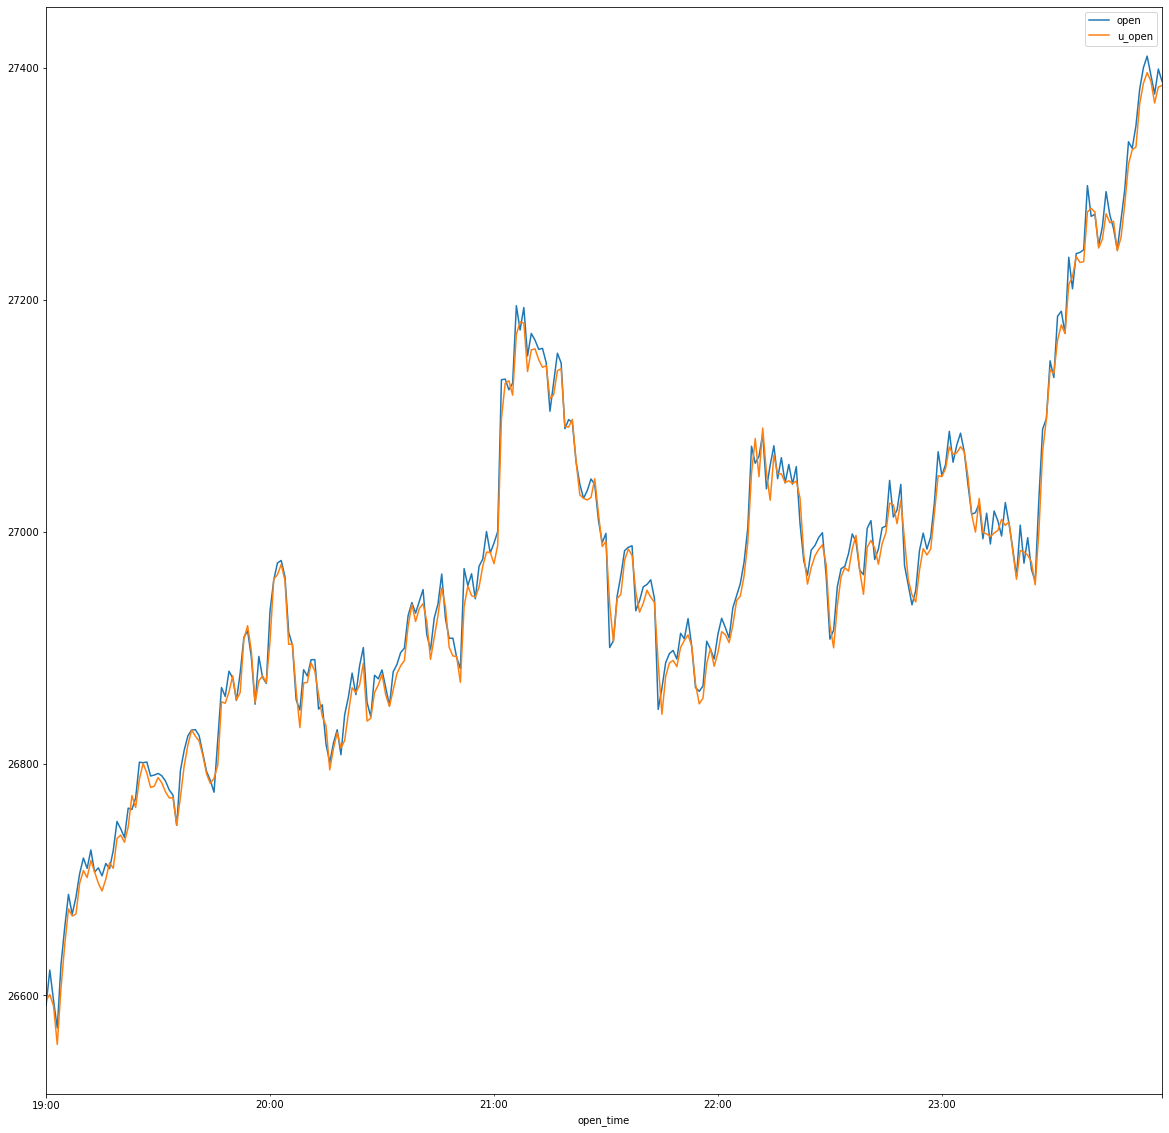

In [386]:
df_compare[['open','u_open']][-300:].plot(figsize=(20,20))